## Import the modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV, RepeatedKFold, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc, accuracy_score, confusion_matrix, f1_score, classification_report

In [2]:
df = pd.read_csv("aug_train.csv")
df2 = pd.read_csv("aug_test.csv")

In [3]:
df["city"] = df['city'].replace('city_','',regex=True).astype('int')
df2["city"] = df2['city'].replace('city_','',regex=True).astype('int')

df = df.drop(columns=["city"])
df2 = df2.drop(columns=["city"])

## Looking at missing data

In [4]:
def count_percent(data):
    df_cols = pd.DataFrame({'Count Missing': data.isnull().sum(),
                        'Percent Missing': data.isnull().sum()*100/data.shape[0]})
    return df_cols

df_cols = count_percent(df)
print(df_cols[df_cols['Count Missing']>0],'\n')

                     Count Missing  Percent Missing
gender                        4508        23.530640
enrolled_university            386         2.014824
education_level                460         2.401086
major_discipline              2813        14.683161
experience                      65         0.339284
company_size                  5938        30.994885
company_type                  6140        32.049274
last_new_job                   423         2.207955 



<AxesSubplot:>

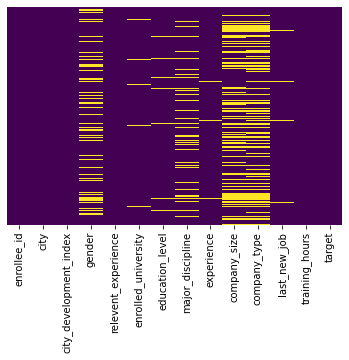

In [5]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

<AxesSubplot:>

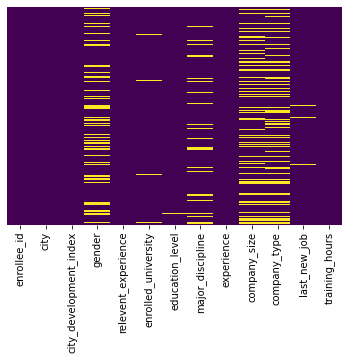

In [6]:
sns.heatmap(df2.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [7]:
df = df.dropna()
df2 = df2.dropna()

```python
# we can't do this
df["gender"] = df["gender"].fillna("Unknown")
df2["gender"] = df2["gender"].fillna("Unknown")

df["enrolled_university"] = df["enrolled_university"].fillna("Unknown")
df2["enrolled_university"] = df2["enrolled_university"].fillna("Unknown")

df["education_level"] = df["education_level"].fillna("Unknown")
df2["education_level"] = df2["education_level"].fillna("Unknown")

df["major_discipline"] = df["major_discipline"].fillna("Unknown")
df2["major_discipline"] = df2["major_discipline"].fillna("Unknown")

df["experience"] = df["experience"].fillna("Unknown")
df2["experience"] = df2["experience"].fillna("Unknown")

df["company_size"] = df["company_size"].fillna("Unknown")
df2["company_size"] = df2["company_size"].fillna("Unknown")

df["company_type"] = df["company_type"].fillna("Unknown")
df2["company_type"] = df2["company_type"].fillna("Unknown")

df["last_new_job"] = df["last_new_job"].fillna("Unknown")
df2["last_new_job"] = df2["last_new_job"].fillna("Unknown")
```

(8955, 14)


<AxesSubplot:>

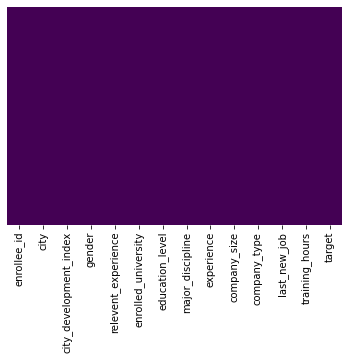

In [8]:
print(df.shape)
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [9]:
df = df.drop(columns=["enrollee_id"])
df2 = df2.drop(columns=["enrollee_id"])

In [10]:
df.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
1,40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
4,162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
7,46,0.762,Male,Has relevent experience,no_enrollment,Graduate,STEM,13,<10,Pvt Ltd,>4,18,1.0
8,103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,7,50-99,Pvt Ltd,1,46,1.0
11,103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,5,5000-9999,Pvt Ltd,1,108,0.0


In [11]:
# perfect nothing is missing now
df_cols = count_percent(df)
print(df_cols[df_cols['Count Missing']>0],'\n')

df_cols = count_percent(df2)
print(df_cols[df_cols['Count Missing']>0],'\n')

Empty DataFrame
Columns: [Count Missing, Percent Missing]
Index: [] 

Empty DataFrame
Columns: [Count Missing, Percent Missing]
Index: [] 



In [12]:
# print(df.isnull().sum(),df2.isnull().sum())

In [13]:
df.dtypes

city                        int64
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object

In [14]:
df2.dtypes

city                        int64
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
dtype: object

In [15]:
train = df
test = df2

In [16]:
from sklearn.preprocessing import LabelEncoder

# I do this manually to explicitly tell the model that a better education & experience serves well as a trustworthy input.

# However, later we wil see the feature importanes report in SHAP and notice interesting results.
experience_dict = {'Has relevent experience' : 1,
             'No relevent experience': 0}

education_dict = {'Graduate' : 2,
             'Masters' : 1,
             'Phd' : 0}

enrollment_dict = {'no_enrollment' : 2,
             'Full time course' : 1,
             'Part time course' : 0}

gender_dict = {'Male' : 2,
             'Female' : 1,
             'Other' : 0}

discipline_dict = {'STEM' : 5,
             'Humanities' : 4,
             'Business Degree' : 3,
             'Other' : 2,
             'No Major' : 1,
             'Arts' : 0 }

company_dict = {'Pvt Ltd' : 5,
             'Funded Startup' : 4,
             'Public Sector' : 3,
             'Early Stage Startup' : 2,
             'NGO' : 1,
             'Other' : 0 }


# Train encoding
le = LabelEncoder()
train['gender'] = train['gender'].map(gender_dict)
train['relevent_experience'] = train['relevent_experience'].map(experience_dict)
train['education_level'] = train['education_level'].map(education_dict)
train['enrolled_university'] = train['enrolled_university'].map(enrollment_dict)
train['major_discipline'] = train['major_discipline'].map(discipline_dict)
train['experience'] = le.fit_transform(train['experience'].astype(str))
train['company_size'] = le.fit_transform(train['company_size'].astype(str))
train['company_type'] = train['company_type'].map(company_dict)
train['last_new_job'] = le.fit_transform(train['last_new_job'].astype(str))

# Test encoding
test['gender'] = le.fit_transform(test['gender'].astype(str))
test['relevent_experience'] = test['relevent_experience'].map(experience_dict)
test['education_level'] = test['education_level'].map(education_dict)
test['enrolled_university'] = test['enrolled_university'].map(enrollment_dict)
test['major_discipline'] = test['major_discipline'].map(discipline_dict)
test['experience'] = le.fit_transform(test['experience'].astype(str))
test['company_size'] = le.fit_transform(test['company_size'].astype(str))
test['company_type'] = test['company_type'].map(company_dict)
test['last_new_job'] = le.fit_transform(test['last_new_job'].astype(str))

In [17]:
type(train)

pandas.core.frame.DataFrame

## Missing Values Imputation

A more sophisticated approach is to use the IterativeImputer class, which models each feature with missing values as a function of other features, and uses that estimate for imputation. It does so in an iterated round-robin fashion: at each step, a feature column is designated as output y and the other feature columns are treated as inputs X. A regressor is fit on (X, y) for known y. Then, the regressor is used to predict the missing values of y. This is done for each feature in an iterative fashion, and then is repeated for max_iter imputation rounds. The results of the final imputation round are returned.

In [18]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.linear_model import LinearRegression

lr = LinearRegression()

train_col_names = list(train.columns.values.tolist())
test_col_names = list(test.columns.values.tolist())

mice_imputer = IterativeImputer(random_state=42, estimator=lr, 
                                max_iter=10, n_nearest_features=2, imputation_order = 'roman')
train = mice_imputer.fit_transform(train)
test = mice_imputer.fit_transform(test)

train = pd.DataFrame(train)
test = pd.DataFrame(test)

train.columns = train_col_names
test.columns = test_col_names

In [19]:
train.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,40.0,0.776,2.0,0.0,2.0,2.0,5.0,6.0,4.0,5.0,4.0,47.0,0.0
1,162.0,0.767,2.0,1.0,2.0,1.0,5.0,21.0,4.0,4.0,3.0,8.0,0.0
2,46.0,0.762,2.0,1.0,2.0,2.0,5.0,4.0,7.0,5.0,4.0,18.0,1.0
3,103.0,0.920,2.0,1.0,2.0,2.0,5.0,17.0,4.0,5.0,0.0,46.0,1.0
4,103.0,0.920,2.0,1.0,2.0,2.0,5.0,15.0,6.0,5.0,0.0,108.0,0.0


In [20]:
X, y = train.loc[:, df.columns != "target"], train["target"]
X_pred = test.loc[:].to_numpy()

## Dataset is imbalanced

[medium link](https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb)

In [21]:
from imblearn.over_sampling import SMOTE,ADASYN, SVMSMOTE
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split

svm_smote = SMOTE( random_state=101) #,sampling_strategy='minority', k_neighbors=5)
X_svm_smote, y_svm_smote = svm_smote.fit_resample(X,y)

X_train_svm, X_test_svm, y_train, y_test = train_test_split(X_svm_smote,y_svm_smote, test_size=0.30, random_state=101)

sc = StandardScaler()
X_train = sc.fit_transform(X_train_svm)
X_test = sc.transform(X_test_svm)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [22]:
# model accuracy
result = []

In [23]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))

    sns.set(font_scale=1)
    labels = [0,1]
    # representing A in heatmap format
    cmap1=sns.light_palette("orange")
    cmap2=sns.light_palette("#34c3eb")
    cmap3=sns.light_palette("purple")
    
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap1, fmt=".3f", xticklabels=labels, yticklabels=labels,annot_kws={"size":14})
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap2, fmt=".3f", xticklabels=labels, yticklabels=labels,annot_kws={"size":14})
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap3, fmt=".3f", xticklabels=labels, yticklabels=labels,annot_kws={"size":14})
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()


def plot_roc_auc(y_test,y_pred):
    from plot_metric.functions import BinaryClassification
    # Visualisation with plot_metric
    bc = BinaryClassification(y_test, y_pred, labels=["Class 1", "Class 0"])

    # Figures
    plt.figure(figsize=(8,7))
    bc.plot_roc_curve()
    
    plt.show()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[20:43:29] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:43:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:43:42] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if yo

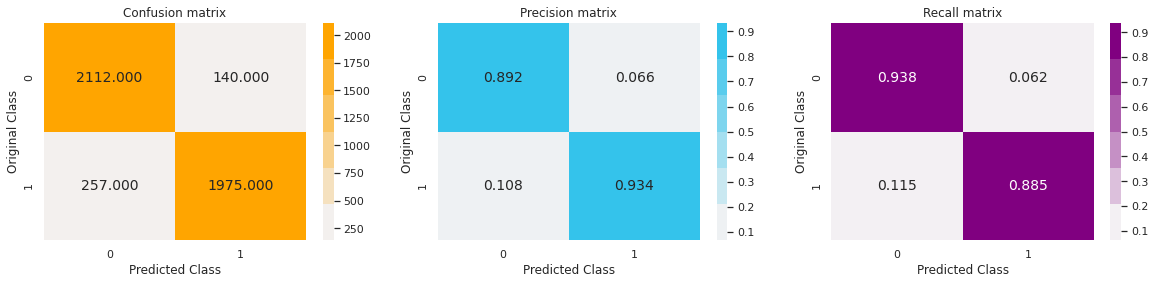

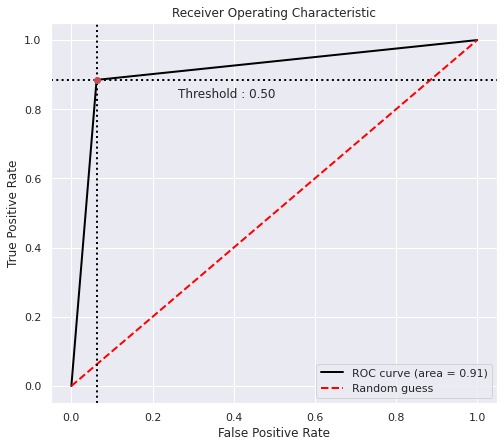

In [24]:
import xgboost as xgb
from sklearn.calibration import CalibratedClassifierCV

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.1], #so called `eta` value
              'max_depth': [5],
              'min_child_weight': [7],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [1000], #number of trees, change it to 1000 for better results
              'seed': [1337]}

XGB = xgb.XGBClassifier()
XGB = GridSearchCV(XGB, parameters, cv = StratifiedKFold(5, shuffle=True), 
                   scoring='roc_auc',
                   verbose=1, refit=True)
# XGB = CalibratedClassifierCV(XGB, method="sigmoid")
XGB.fit(X_train, y_train)
y_pred_xgb = XGB.predict(X_test)
cm_xgb = confusion_matrix(y_pred_xgb,y_test)
fscore = f1_score(y_test,y_pred_xgb)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
result.append(acc_xgb)


print("RESULTS : ")
print("XGBoost Model Accuracy : ",round(acc_xgb,2))
print("XGBoost Model F1-score : ",round(fscore,2))
print("Classification Report :\n",classification_report(y_test,y_pred_xgb))
print('\n')
plot_confusion_matrix(y_test, y_pred_xgb)
print('\n')
plot_roc_auc(y_test,y_pred_xgb)

In [25]:
from sklearn.inspection import permutation_importance
import eli5
from eli5.sklearn import PermutationImportance

pimp = PermutationImportance(estimator = XGB, 
                                         scoring = 'f1', random_state=101, n_iter = 5)
pimp.fit(X_test, y_test)

print(eli5.show_weights(pimp, feature_names = X.columns.to_list()))

feature_imp = pd.DataFrame(np.hstack((np.array([X.columns[0:]]).T, 
                              pimp.feature_importances_.T.reshape(-1,1))), 
                              columns=['feature', 'importance'])

feature_imp['importance'] = pd.to_numeric(feature_imp['importance'])
feature_imp.sort_values(by='importance', ascending=False)

<IPython.core.display.HTML object>


,feature,importance
10,last_new_job,0.053692
1,city_development_index,0.044894
8,company_size,0.041466
4,enrolled_university,0.031793
5,education_level,0.031225
9,company_type,0.021330
3,relevent_experience,0.019826
0,city,0.017187
7,experience,0.013309
2,gender,0.009426


<AxesSubplot:xlabel='importance', ylabel='feature'>

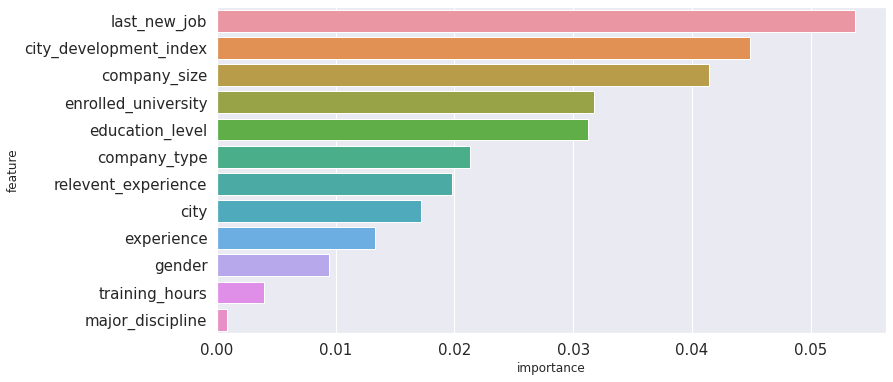

In [26]:
plt.figure(figsize = (12,6))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# We sort by importance and get the features
sns.barplot(x = 'importance', y = 'feature', data = feature_imp, 
            order = feature_imp.sort_values('importance', ascending=False).feature)